In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.neighbors

from PIL import Image
from matplotlib.pyplot import figure

DATA_DIR = ""


In [10]:
image1 = 0
image2 = 1

In [6]:
def show_image(image_index, train_set=True):
    """Display image with given index.

    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    image = Image.open(
        os.path.join(DATA_DIR, f'images_{dataset}/{image_index}.jpg'))
    plt.imshow(image)
    plt.show()

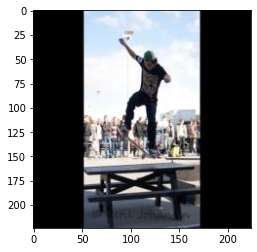

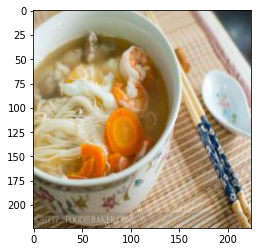

(None, None)

In [12]:
show_image(image1), show_image(image2)

In [13]:
def get_tags(image_index, train_set=True):
    """Get tags of image with given index.

    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.

    Returns
    -------
    tags: list of string
        List of tags associated with each image.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'tags_{dataset}/{image_index}.txt'))
    tags = f.readlines()
    f.close()
    # Some post processing
    tags = [t.strip("\n.") for t in tags]
    return tags

In [ ]:
def get_feat_matrix(train_set=True):
    """Get feature matrix for given dataset

    Parameters
    ----------
    train_set: bool (default=True)
        Whether to look in the train or in the test set.

    Returns
    -------
    X: ndarray of shape (n, 1000)
        A matrix containing the ResNet features for the train or test images.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    feats = pd.read_csv(
        os.path.join(DATA_DIR, f'features_{dataset}/features_resnet1000_{dataset}.csv'),
        names = ['Image']+["X{}".format(i) for i in range(1000)])
    # Need to sort data
    feats["Image"] = feats["Image"].apply(lambda s: int(s.split("/")[1].split(".jpg")[0]))
    feats.sort_values(by="Image", inplace=True)
    X = feats.values[:, 1:]
    return X

In [18]:
def get_description(image_index, train_set=True):
    """Get description of image with given index.

    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.

    Returns
    -------
    description: string
        The description of the image as a paragraph of text with punctuation removed.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'descriptions_{dataset}/{image_index}.txt'))
    desc = f.read()
    f.close()
    # Some post-processing
    desc = desc.replace(".", " ")
    desc = desc.replace("\n", " ")
    return desc

In [14]:
# Some preliminaries
# Comment this out after you run it for the first time

# Install packages
!pip install gensim
import gensim

# Download files
import urllib.request
import os
# You can change the path to the downloaded file here
if not os.path.exists("GoogleNews-vectors-negative300.bin.gz"):
    urllib.request.urlretrieve("https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz", filename="GoogleNews-vectors-negative300.bin.gz")

You should consider upgrading via the 'c:\users\marti\pycharmprojects\uncertainty-projects\venv\scripts\python.exe -m pip install --upgrade pip' command.


In [15]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)
print("Loaded word vectors successfully!")

Loaded word vectors successfully!


In [19]:
train_desc = [get_description(i) for i in range(10000)]
test_desc = [get_description(i, train_set=False) for i in range(2000)]

In [21]:
def doc_to_vec(sentence, word2vec):
    """Convert text to a 300-dimensional vector

    Each word is converted to a vector via the word-to-vec model and the vectors are averaged
    to give the final result.

    Parameters
    ----------
    sentence: string
        Text to be converted to a vector.
    word2vec: word2vec model
        Movel to be used for vectorization.

    Returns
    -------
    vec: array of shape (300, )
        Vector that represents the average of word2vec-transformed vectors for the given sentence.
    """
    word_vecs = [word2vec.get_vector(w.lower()) for w in sentence.split() if w.lower() in word2vec.key_to_index]
    # Return average
    return np.stack(word_vecs).mean(0)


In [112]:
def tags_to_vec(tags, word2vec):
    """Convert text to a 300-dimensional vector

    Each word is converted to a vector via the word-to-vec model and the vectors are averaged
    to give the final result.

    Parameters
    ----------
    sentence: string
        Text to be converted to a vector.
    word2vec: word2vec model
        Movel to be used for vectorization.

    Returns
    -------
    vec: array of shape (300, )
        Vector that represents the average of word2vec-transformed vectors for the given sentence.
    """
    word_vecs = [word2vec.get_vector(w.lower()) for w in tags if w.lower() in word2vec.key_to_index]
    # Return average
    if len(word_vecs) == 0:
        return np.zeros([1,300])[0]
    else:
        return np.stack(word_vecs).mean(0)

In [24]:
X = np.array([doc_to_vec(s, word2vec) for s in train_desc])
X_test = np.array([doc_to_vec(s, word2vec) for s in test_desc])

In [103]:
def get_tags(image_index, train_set=True):
    """Get description of image with given index.

    Parameters
    ----------
    image_index: int
        Numeric index of the image (max 9999 for train, max 1999 for test).
    train_set: bool (default=True)
        Whether to look in the train or in the test set.

    Returns
    -------
    description: string
        The description of the image as a paragraph of text with punctuation removed.
    """
    if train_set:
        dataset = 'train'
    else:
        dataset = 'test'
    f = open(
        os.path.join(DATA_DIR, f'tags_{dataset}/{image_index}.txt'))
    # print(image_index)
    filesize = os.path.getsize(f.name)
    if filesize == 0:
        return ['']
    else:
        return pd.read_csv(f, sep=':', header=None)[1].to_list()

In [113]:
test_tags_objects = [get_tags(i, train_set=False) for i in range(2000)]

In [114]:
test_tag_vec = np.array([tags_to_vec(s, word2vec) for s in test_tags_objects])

In [115]:
np.stack(test_tag_vec, axis=0)

array([[ 0.03146362, -0.03942871, -0.01617432, ..., -0.02742004,
        -0.09115601,  0.1953125 ],
       [ 0.18945312, -0.07519531, -0.15625   , ...,  0.08789062,
        -0.08789062, -0.11523438],
       [ 0.25341797, -0.08251953, -0.01641846, ...,  0.06835938,
        -0.01708984,  0.11694336],
       ...,
       [ 0.20605469,  0.12670898,  0.00244141, ..., -0.05941582,
         0.03668213, -0.08609009],
       [ 0.16894531, -0.20019531, -0.16113281, ...,  0.16699219,
        -0.0123291 , -0.20410156],
       [-0.09875488,  0.01643372,  0.14361572, ...,  0.03567505,
        -0.13037109,  0.00756836]])

In [118]:
X_test

array([[ 6.6214100e-02,  8.0905491e-03, -3.0562789e-03, ...,
        -6.7333080e-02,  2.2594310e-02, -2.5235776e-02],
       [-3.7848979e-02, -9.9532185e-03,  1.2738396e-02, ...,
        -7.9831798e-03, -4.1863833e-02, -6.3026875e-02],
       [ 9.3649469e-02,  7.7612735e-02,  3.8509592e-02, ...,
        -3.4395106e-02,  7.3298737e-02, -9.5809042e-02],
       ...,
       [ 7.5769372e-02,  3.2991975e-05,  2.8739311e-02, ...,
        -6.2089249e-02, -8.3242059e-02,  3.5235430e-03],
       [ 2.4710404e-02,  8.3356358e-02,  3.3125225e-02, ...,
         7.0660240e-03, -4.2935021e-02,  9.3576536e-03],
       [ 9.4850764e-02,  9.0590365e-02,  1.2594533e-02, ...,
        -8.7748682e-03, -4.7249194e-02,  6.1276457e-03]], dtype=float32)

In [135]:
from sklearn.neighbors import NearestNeighbors

NN = NearestNeighbors()
NN.fit(test_tag_vec)
result = NN.kneighbors(X_test, n_neighbors=20, return_distance=False)



In [136]:
result

array([[1683,  111, 1840, ..., 1699, 1412,  121],
       [ 388, 1124, 1086, ..., 1208, 1864, 1866],
       [ 445, 1931, 1208, ...,  452,  649, 1866],
       ...,
       [1702, 1699, 1683, ..., 1208, 1391,  649],
       [1340,  607,  934, ..., 1033, 1842,  111],
       [ 381,  763, 1267, ...,  768,  311, 1208]], dtype=int64)

In [126]:
def get_Kaggle_submission(y_top_20):
    """Get data in Kaggle submission format

    Parameters
    ----------
    y_top_20: ndarray of shape (n, 20)
        A list of top 20 IDs lists that match each of the n descriptions.

    Returns
    -------
    df: pandas.DataFrame
        Dataframe with columns and values that map correctly to Kaggle's expected submission format.
    """
    d = {
        "Description_ID": [f"{i}.txt" for i in range(len(y_top_20))],
        "Top_20_Image_IDs": [" ".join(
            [f"{j}.jpg" for j in y_top_20[i]]
        ) for i in range(len(y_top_20))]
    }
    return pd.DataFrame(d)

In [130]:
get_Kaggle_submission(result).to_csv("only_tags.csv", index=False)